In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Epoch 1/250

Epoch 1: val_loss improved from inf to 0.51343, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 8s - 121ms/step - loss: 0.5914 - mse: 0.5914 - val_loss: 0.5134 - val_mse: 0.5134
Epoch 2/250

Epoch 2: val_loss improved from 0.51343 to 0.50750, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 2s - 23ms/step - loss: 0.5123 - mse: 0.5123 - val_loss: 0.5075 - val_mse: 0.5075
Epoch 3/250

Epoch 3: val_loss did not improve from 0.50750
70/70 - 2s - 22ms/step - loss: 0.5090 - mse: 0.5090 - val_loss: 0.5151 - val_mse: 0.5151
Epoch 4/250

Epoch 4: val_loss improved from 0.50750 to 0.50653, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 2s - 22ms/step - loss: 0.5081 - mse: 0.5081 - val_loss: 0.5065 - val_mse: 0.5065
Epoch 5/250

Epoch 5: val_loss improved from 0.50653 to 0.50547, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 2s - 22ms/step - loss: 0.5057 - mse: 0.5057 - val_loss: 0.5055 - val_mse: 0.5055
Epoch 6/250

Epoch 6: val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.50632, saving model to weights/DnCNN_VehA_48_22.weights.h5
70/70 - 35s - 506ms/step - loss: 0.6049 - mse: 0.6049 - val_loss: 0.5063 - val_mse: 0.5063
Epoch 2/200

Epoch 2: val_loss improved from 0.50632 to 0.50187, saving model to weights/DnCNN_VehA_48_22.weights.h5
70/70 - 4s - 55ms/step - loss: 0.5034 - mse: 0.5034 - val_loss: 0.5019 - val_mse: 0.5019
Epoch 3/200

Epoch 3: val_loss improved from 0.50187 to 0.50125, saving model to weights/DnCNN_VehA_48_22.weights.h5
70/70 - 4s - 55ms/step - loss: 0.5025 - mse: 0.5025 - val_loss: 0.5013 - val_mse: 0.5013
Epoch 4/200

Epoch 4: val_loss did not improve from 0.50125
70/70 - 3s - 48ms/step - loss: 0.5021 - mse: 0.5021 - val_loss: 0.5013 - val_mse: 0.5013
Epoch 5/200

Epoch 5: val_loss did not improve from 0.50125
70/70 - 3s - 48ms/step - loss: 0.5025 - mse: 0.5025 - 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 158 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
SRCNN  val PSNR: 52.87 dB
DnCNN  val PSNR: 52.87 dB


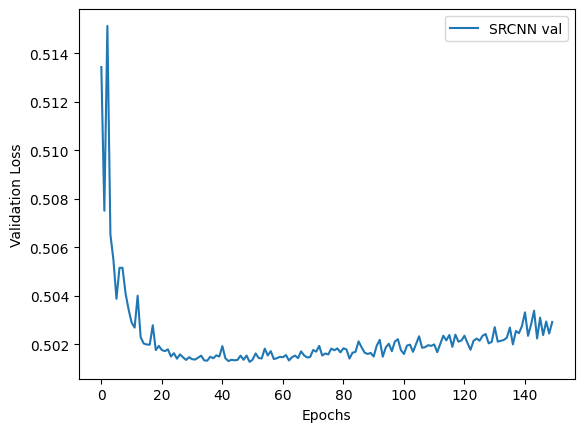

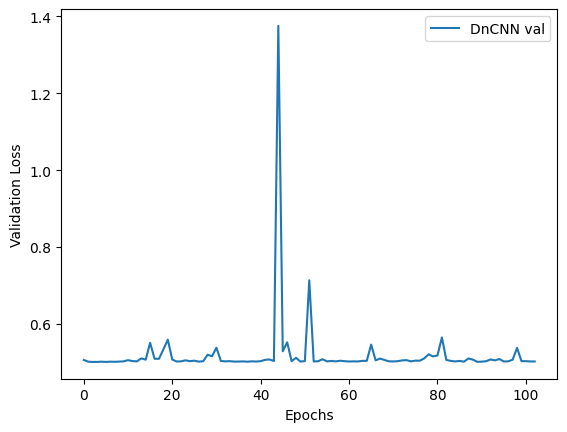

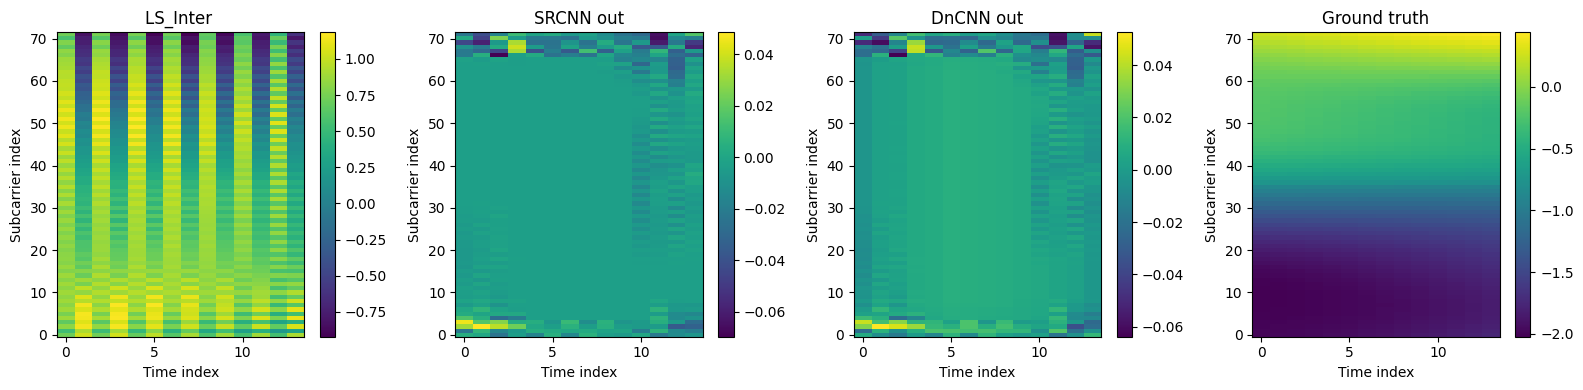

In [ ]:
# Run this entire block in one Colab or Jupyter cell
#MY MAIN CO
# 1) Imports & Mixed‐Precision Speedup
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from scipy import interpolate

import tensorflow as tf
# Enable mixed precision on supported GPUs
tf.keras.mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Subtract
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# -----------------------------------------------------------------------------
# 2) Utility functions: PSNR and pilot interpolation → full grid
# -----------------------------------------------------------------------------
def psnr(target, ref):
    diff = np.asarray(ref, np.float32) - np.asarray(target, np.float32)
    rmse = np.sqrt(np.mean(diff**2))
    # Using 255 peak for compatibility with image‐based PSNR
    return 20 * math.log10(255. / (rmse + 1e-12))

def interpolation(noisy, SNR, Number_of_pilot, method='rbf'):
    N = noisy.shape[0]
    # pack real/imag channels
    data = np.zeros((N,72,14,2), dtype=np.float32)
    data[...,0] = noisy.real
    data[...,1] = noisy.imag

    # select pilot indices
    if Number_of_pilot == 48:
        idx = ([14*i   for i in range(1,72,6)] +
               [4+14*i for i in range(4,72,6)] +
               [7+14*i for i in range(1,72,6)] +
               [11+14*i for i in range(4,72,6)])
    elif Number_of_pilot == 16:
        idx = ([4+14*i for i in range(1,72,9)] +
               [9+14*i for i in range(4,72,9)])
    elif Number_of_pilot == 24:
        idx = ([14*i   for i in range(1,72,9)] +
               [6+14*i  for i in range(4,72,9)] +
               [11+14*i for i in range(1,72,9)])
    elif Number_of_pilot == 8:
        idx = ([4+14*i for i in range(5,72,18)] +
               [9+14*i for i in range(8,72,18)])
    elif Number_of_pilot == 36:
        idx = ([14*i   for i in range(1,72,6)] +
               [6+14*i  for i in range(4,72,6)] +
               [11+14*i for i in range(1,72,6)])
    else:
        raise ValueError("Unsupported pilot count")

    r, c = np.array(idx)//14, np.array(idx)%14
    Xg, Yg = np.meshgrid(np.arange(72), np.arange(14), indexing='ij')
    out = np.zeros((N,72,14,2), dtype=np.float32)
    for n in range(N):
        for comp in (0,1):
            z = data[n, r, c, comp]
            if method=='rbf':
                f = interpolate.Rbf(r, c, z, function='gaussian')
                out[n,...,comp] = f(Xg, Yg)
            else:
                tck = interpolate.bisplrep(r, c, z)
                out[n,...,comp] = interpolate.bisplev(np.arange(72), np.arange(14), tck)
    return out.reshape(N*2, 72, 14, 1)

# -----------------------------------------------------------------------------
# 3) Model definitions: SRCNN & DnCNN
# -----------------------------------------------------------------------------
def build_SRCNN():
    inp = Input((72,14,1))
    x = Conv2D(64,(9,9),activation='relu',
               kernel_initializer='he_normal',padding='same')(inp)
    x = Conv2D(32,(1,1),activation='relu',
               kernel_initializer='he_normal',padding='same')(x)
    out = Conv2D(1,(5,5),kernel_initializer='he_normal',padding='same')(x)
    m = Model(inp,out)
    m.compile(Adam(1e-3), loss='mse', metrics=['mse'])
    return m

def build_DnCNN():
    inp = Input((None,None,1))
    x = Conv2D(64,(3,3),padding='same',activation='relu')(inp)
    for _ in range(18):
        x = Conv2D(64,(3,3),padding='same')(x)
        x = BatchNormalization(epsilon=1e-3)(x)
        x = Activation('relu')(x)
    noise = Conv2D(1,(3,3),padding='same')(x)
    out   = Subtract()([inp, noise])
    m = Model(inp,out)
    m.compile(Adam(1e-3), loss='mse', metrics=['mse'])
    return m

# -----------------------------------------------------------------------------
# 4) Training helpers with checkpoints & early stopping
# -----------------------------------------------------------------------------
def train_SRCNN(X_tr, Y_tr, X_val, Y_val, chan, npilots, snr):
    Path("weights").mkdir(exist_ok=True)
    model = build_SRCNN()
    ck = ModelCheckpoint(
        f"weights/SRCNN_{chan}_{npilots}_{snr}.weights.h5",
        monitor='val_loss', save_best_only=True,
        save_weights_only=True, verbose=1
    )
    es = EarlyStopping(patience=100, restore_best_weights=True)
    hist = model.fit(
        X_tr, Y_tr, validation_data=(X_val,Y_val),
        epochs=250, batch_size=128,
        callbacks=[ck, es], verbose=2
    )
    return model, hist

def train_DnCNN(Z_tr, Y_tr, Z_val, Y_val, chan, npilots, snr):
    Path("weights").mkdir(exist_ok=True)
    model = build_DnCNN()
    ck = ModelCheckpoint(
        f"weights/DnCNN_{chan}_{npilots}_{snr}.weights.h5",
        monitor='val_loss', save_best_only=True,
        save_weights_only=True, verbose=1
    )
    es = EarlyStopping(patience=100, restore_best_weights=True)
    hist = model.fit(
        Z_tr, Y_tr, validation_data=(Z_val,Y_val),
        epochs=200, batch_size=128,
        callbacks=[ck, es], verbose=2
    )
    return model, hist

# -----------------------------------------------------------------------------
# 5) Prediction helpers
# -----------------------------------------------------------------------------
def predict_SRCNN(X, chan, npilots, snr):
    m = build_SRCNN()
    m.load_weights(f"weights/SRCNN_{chan}_{npilots}_{snr}.weights.h5")
    return m.predict(X, batch_size=128, verbose=1)

def predict_DnCNN(Z, chan, npilots, snr):
    m = build_DnCNN()
    m.load_weights(f"weights/DnCNN_{chan}_{npilots}_{snr}.weights.h5")
    return m.predict(Z, batch_size=128, verbose=1)

# -----------------------------------------------------------------------------
# 6) Main: load datasets, train, predict, evaluate, and plot
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    channel_model    = "VehA"
    SNR              = 22
    Number_of_pilots = 48

    # -- load Perfect_Veha.mat
    perfect = loadmat("/content/drive/MyDrive/Projects/Akash/Perfect_"+ 'VehA.mat')['My_perfect_H']
    noisy_input = loadmat("/content/drive/MyDrive/Projects/Akash/Noisy_" + channel_model + "_" + "SNR_" + str(SNR) + ".mat") ["My"+"_noisy_"+ "H"]

    # -- interpolate to full grid
    X = interpolation(noisy_input, SNR, Number_of_pilots, method="rbf")

    # -- build labels Y (2N,72,14,1)
    N = perfect.shape[0]
    Ytmp = np.zeros((N,72,14,2), dtype=np.float32)
    Ytmp[...,0] = perfect.real
    Ytmp[...,1] = perfect.imag
    Y = Ytmp.transpose(3,0,1,2).reshape(2*N,72,14,1)

    # -- train/val split
    mask       = np.random.rand(len(Y)) < (1/9)
    X_tr, Y_tr = X[mask], Y[mask]
    X_val, Y_val = X[~mask], Y[~mask]

    ###### -- 6.1 SRCNN
    srcnn_model, hist_src = train_SRCNN(
        X_tr, Y_tr, X_val, Y_val,
        channel_model, Number_of_pilots, SNR
    )
    pred_src_val = predict_SRCNN(
        X_val, channel_model, Number_of_pilots, SNR
    )

    ######### -- 6.2 DnCNN (use SRCNN outputs as input)
    Z_tr = predict_SRCNN(X_tr, channel_model, Number_of_pilots, SNR)
    Z_val= predict_SRCNN(X_val, channel_model, Number_of_pilots, SNR)
    dncnn_model, hist_dn = train_DnCNN(
        Z_tr, Y_tr, Z_val, Y_val,
        channel_model, Number_of_pilots, SNR
    )
    pred_dn_val = predict_DnCNN(
        Z_val, channel_model, Number_of_pilots, SNR
    )

    # -- 6.3 Compute PSNR
    psnr_src = np.mean([
        psnr(Y_val[i].squeeze(), pred_src_val[i].squeeze())
        for i in range(len(pred_src_val))
    ])
    psnr_dn = np.mean([
        psnr(Y_val[i].squeeze(), pred_dn_val[i].squeeze())
        for i in range(len(pred_dn_val))
    ])
    print(f"SRCNN  val PSNR: {psnr_src:.2f} dB")
    print(f"DnCNN  val PSNR: {psnr_dn:.2f} dB")

    # -- 6.4 Plot losses
    plt.figure()
    plt.plot(hist_src.history["val_loss"], label="SRCNN val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(hist_dn.history["val_loss"], label="DnCNN val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend(); plt.show()

    # -- 6.5 Visualize one example
    k = 5
    examples = [
        X_val[k].squeeze(),
        pred_src_val[k].squeeze(),
        pred_dn_val[k].squeeze(),
        Y_val[k].squeeze()
    ]
    titles = ["LS_Inter ", "SRCNN out", "DnCNN out", "Ground truth"]
    fig, axes = plt.subplots(1,4,figsize=(16,4))
    for ax, img, tt in zip(axes, examples, titles):
        pcm = ax.imshow(img, origin="lower", aspect="auto")
        ax.set_title(tt)
         # Add X and Y axis labels for each subplot
        ax.set_xlabel("Time index")  # Time index for X-axis (if the data corresponds to time)
        ax.set_ylabel("Subcarrier index")  # Subcarrier index for Y-axis (frequency subcarriers
        fig.colorbar(pcm, ax=ax)
    plt.tight_layout(); plt.show()


Epoch 1/150

Epoch 1: val_loss improved from inf to 0.51190, saving model to weights/SRCNN_VehA_48_22.weights.h5
71/71 - 10s - 148ms/step - loss: 0.5651 - mse: 0.5651 - val_loss: 0.5119 - val_mse: 0.5119
Epoch 2/150

Epoch 2: val_loss improved from 0.51190 to 0.50825, saving model to weights/SRCNN_VehA_48_22.weights.h5
71/71 - 5s - 77ms/step - loss: 0.5217 - mse: 0.5217 - val_loss: 0.5083 - val_mse: 0.5083
Epoch 3/150

Epoch 3: val_loss improved from 0.50825 to 0.50531, saving model to weights/SRCNN_VehA_48_22.weights.h5
71/71 - 4s - 62ms/step - loss: 0.5189 - mse: 0.5189 - val_loss: 0.5053 - val_mse: 0.5053
Epoch 4/150

Epoch 4: val_loss did not improve from 0.50531
71/71 - 3s - 46ms/step - loss: 0.5170 - mse: 0.5170 - val_loss: 0.5068 - val_mse: 0.5068
Epoch 5/150

Epoch 5: val_loss improved from 0.50531 to 0.50357, saving model to weights/SRCNN_VehA_48_22.weights.h5
71/71 - 5s - 72ms/step - loss: 0.5164 - mse: 0.5164 - val_loss: 0.5036 - val_mse: 0.5036
Epoch 6/150

Epoch 6: val_los

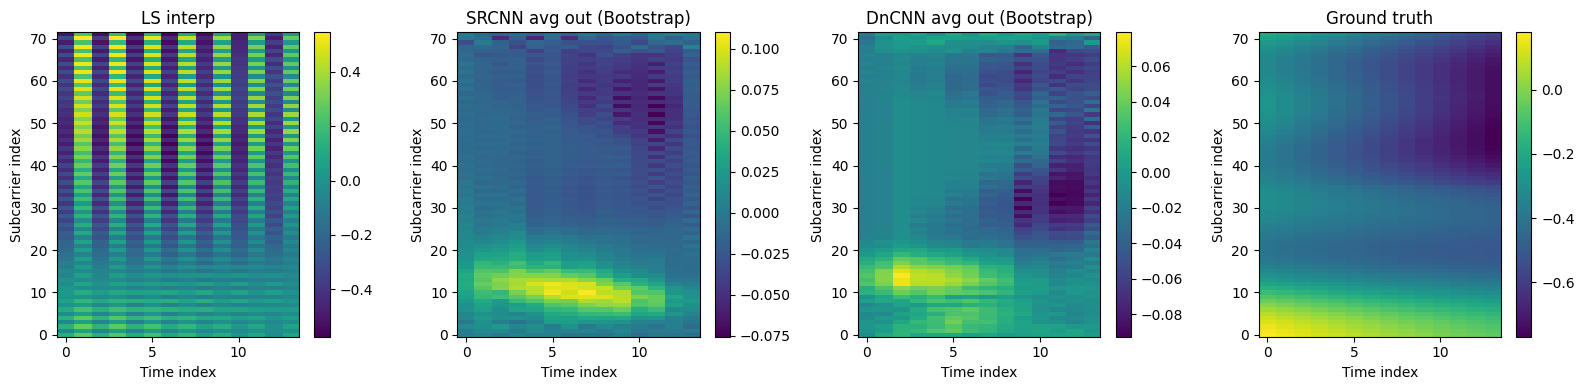

In [ ]:
# Import necessary libraries for bootstrapping
from sklearn.utils import resample

# Function to perform bootstrap resampling
def bootstrap_resample(X, Y, n_iterations):
    resampled_X = []
    resampled_Y = []
    for _ in range(n_iterations):
        X_resampled, Y_resampled = resample(X, Y, n_samples=len(X), random_state=42)
        resampled_X.append(X_resampled)
        resampled_Y.append(Y_resampled)
    return resampled_X, resampled_Y

# Define the number of bootstrap iterations
n_iterations = 2  # You can change this number based on how many bootstraps you want

# Perform bootstrap resampling on the training data
X_bootstrap, Y_bootstrap = bootstrap_resample(X_tr, Y_tr, n_iterations)

# Initialize lists to store predictions from each bootstrap iteration
srcnn_predictions = []
dncnn_predictions = []

# Loop over each bootstrap iteration
for i in range(n_iterations):
    # Train SRCNN on the resampled data
    srcnn_model, _ = train_SRCNN(X_bootstrap[i], Y_bootstrap[i], X_val, Y_val, channel_model, Number_of_pilots, SNR)
    pred_src_val = predict_SRCNN(X_val, channel_model, Number_of_pilots, SNR)
    srcnn_predictions.append(pred_src_val)

    # Train DnCNN on SRCNN predictions as input (Resample data with SRCNN outputs)
    Z_bootstrap = predict_SRCNN(X_bootstrap[i], channel_model, Number_of_pilots, SNR)
    dncnn_model, _ = train_DnCNN(Z_bootstrap, Y_bootstrap[i], Z_val, Y_val, channel_model, Number_of_pilots, SNR)
    pred_dn_val = predict_DnCNN(Z_val, channel_model, Number_of_pilots, SNR)
    dncnn_predictions.append(pred_dn_val)

# After all iterations, average the predictions from all bootstrap models
avg_pred_srcnn = np.mean(np.array(srcnn_predictions), axis=0)
avg_pred_dncnn = np.mean(np.array(dncnn_predictions), axis=0)

# Visualizing the results (LS interpolation, SRCNN avg out, DnCNN avg out, and Ground truth)
k = 0
examples = [
    X_val[k].squeeze(),  # LS interpolation of noisy data
    avg_pred_srcnn[k].squeeze(),  # Average SRCNN output from bootstrap
    avg_pred_dncnn[k].squeeze(),  # Average DnCNN output from bootstrap
    Y_val[k].squeeze()  # Ground truth (perfect data)
]
titles = ["LS interp", "SRCNN avg out (Bootstrap)", "DnCNN avg out (Bootstrap)", "Ground truth"]

# Plot the images with Time and Subcarrier indices as axes
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, img, tt in zip(axes, examples, titles):
    pcm = ax.imshow(img, origin="lower", aspect="auto")
    ax.set_title(tt)
    ax.set_xlabel("Time index")  # Time index for X-axis
    ax.set_ylabel("Subcarrier index")  # Subcarrier index for Y-axis
    fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()


Epoch 1/300

Epoch 1: val_loss improved from inf to 0.55247, saving model to weights/SRCNN_VehA4812.weights.h5
70/70 - 7s - 100ms/step - loss: 0.5818 - mse: 0.5818 - val_loss: 0.5525 - val_mse: 0.5525
Epoch 2/300

Epoch 2: val_loss improved from 0.55247 to 0.53252, saving model to weights/SRCNN_VehA4812.weights.h5
70/70 - 2s - 23ms/step - loss: 0.5337 - mse: 0.5337 - val_loss: 0.5325 - val_mse: 0.5325
Epoch 3/300

Epoch 3: val_loss improved from 0.53252 to 0.52224, saving model to weights/SRCNN_VehA4812.weights.h5
70/70 - 2s - 23ms/step - loss: 0.5201 - mse: 0.5201 - val_loss: 0.5222 - val_mse: 0.5222
Epoch 4/300

Epoch 4: val_loss improved from 0.52224 to 0.51869, saving model to weights/SRCNN_VehA4812.weights.h5
70/70 - 2s - 22ms/step - loss: 0.5145 - mse: 0.5145 - val_loss: 0.5187 - val_mse: 0.5187
Epoch 5/300

Epoch 5: val_loss improved from 0.51869 to 0.51661, saving model to weights/SRCNN_VehA4812.weights.h5
70/70 - 2s - 22ms/step - loss: 0.5114 - mse: 0.5115 - val_loss: 0.5166 -

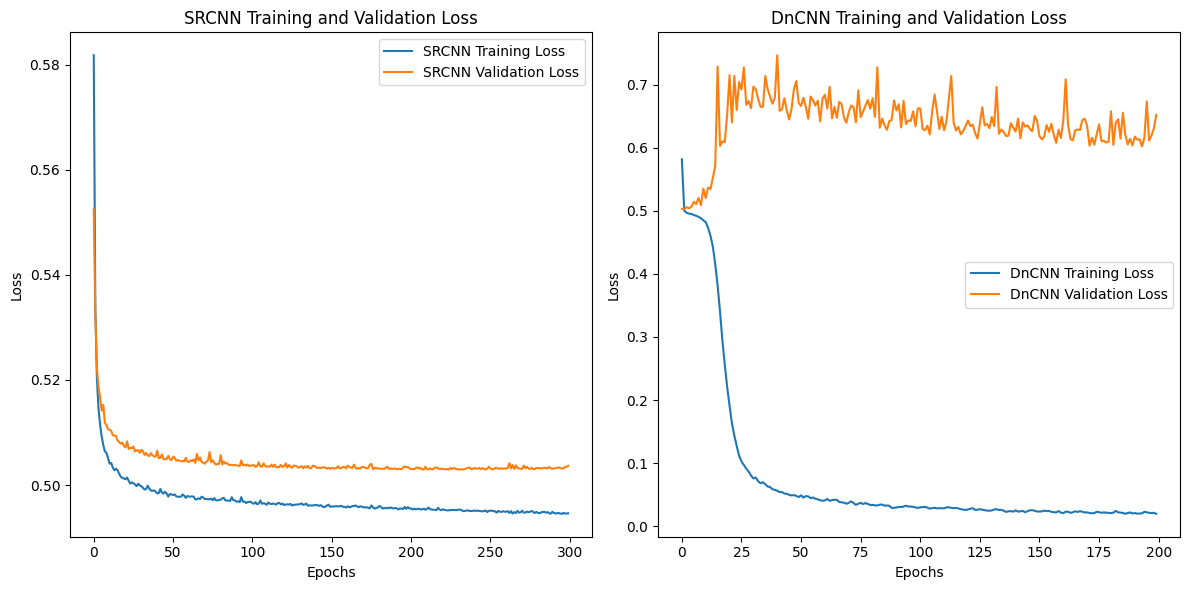

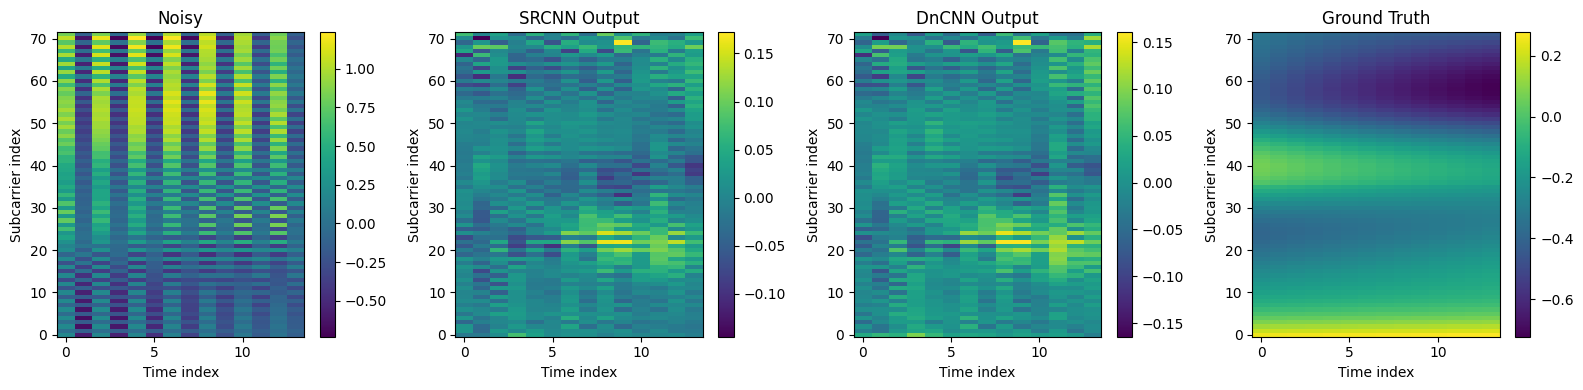

In [ ]:
import numpy as np
import math
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import interpolate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Subtract
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# -------------------------------------------------------------------------
# Utility Functions
# -------------------------------------------------------------------------
def psnr(target, ref):
    target_data = np.array(target, dtype=float)
    ref_data    = np.array(ref, dtype=float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff.flatten()**2))
    return 20 * math.log10(255. / (rmse + 1e-12))

def interpolation(noisy, SNR, Number_of_pilot, interp='rbf'):
    noisy_image = np.zeros((40000, 72, 14, 2), dtype=np.float32)
    noisy_image[..., 0] = noisy.real
    noisy_image[..., 1] = noisy.imag

    if Number_of_pilot == 48:
        idx = ([14*i for i in range(1, 72, 6)] +
               [4 + 14*i for i in range(4, 72, 6)] +
               [7 + 14*i for i in range(1, 72, 6)] +
               [11 + 14*i for i in range(4, 72, 6)])
    elif Number_of_pilot == 16:
        idx = ([4 + 14*i for i in range(1, 72, 9)] +
               [9 + 14*i for i in range(4, 72, 9)])
    elif Number_of_pilot == 24:
        idx = ([14*i for i in range(1, 72, 9)] +
               [6 + 14*i for i in range(4, 72, 9)] +
               [11 + 14*i for i in range(1, 72, 9)])
    elif Number_of_pilot == 8:
        idx = ([4 + 14*i for i in range(5, 72, 18)] +
               [9 + 14*i for i in range(8, 72, 18)])
    elif Number_of_pilot == 36:
        idx = ([14*i for i in range(1, 72, 6)] +
               [6 + 14*i for i in range(4, 72, 6)] +
               [11 + 14*i for i in range(1, 72, 6)])
    else:
        raise ValueError("Unsupported pilot count")

    r = np.array(idx)//14
    c = np.array(idx)%14
    Xg, Yg = np.meshgrid(np.arange(72), np.arange(14), indexing='ij')
    out = np.zeros((noisy.shape[0], 72, 14, 2), dtype=np.float32)

    for n in range(noisy.shape[0]):
        for comp in (0, 1):
            z = noisy_image[n, r, c, comp]
            if interp == 'rbf':
                f = interpolate.Rbf(r, c, z, function='gaussian')
                out[n, ..., comp] = f(Xg, Yg)
            else:
                tck = interpolate.bisplrep(r, c, z)
                out[n, ..., comp] = interpolate.bisplev(np.arange(72), np.arange(14), tck)

    return out.reshape(noisy.shape[0]*2, 72, 14, 1)

# -------------------------------------------------------------------------
# SRCNN Model
# -------------------------------------------------------------------------
def SRCNN_model():
    inp = Input((72, 14, 1))
    x = Conv2D(64, (9, 9), activation='relu', kernel_initializer='he_normal', padding='same')(inp)
    x = Conv2D(32, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    out = Conv2D(1, (5, 5), kernel_initializer='he_normal', padding='same')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(Adam(1e-4), loss='mse', metrics=['mse'])
    return model

# -------------------------------------------------------------------------
# DnCNN Model
# -------------------------------------------------------------------------
def DNCNN_model():
    inp = Input((None, None, 1))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inp)
    for _ in range(18):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization(epsilon=1e-3)(x)
        x = Activation('relu')(x)
    noise = Conv2D(1, (3, 3), padding='same')(x)
    out = Subtract()([inp, noise])
    model = Model(inputs=inp, outputs=out)
    model.compile(Adam(1e-4), loss='mse', metrics=['mse'])
    return model

# -------------------------------------------------------------------------
# Training Functions
# -------------------------------------------------------------------------
def SRCNN_train(X_tr, Y_tr, X_val, Y_val, channel_model, num_pilots, SNR):
    m  = SRCNN_model()
    ck = ModelCheckpoint(f"weights/SRCNN_{channel_model}{num_pilots}{SNR}.weights.h5",
                         monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
    h = m.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=300, batch_size=128, callbacks=[ck], verbose=2)
    return m, h

def SRCNN_predict(X, channel_model, num_pilots, SNR):
    m = SRCNN_model()
    m.load_weights(f"weights/SRCNN_{channel_model}{num_pilots}{SNR}.weights.h5")
    return m.predict(X, batch_size=128, verbose=1)

def DNCNN_train(X_tr, Y_tr, X_val, Y_val, channel_model, num_pilots, SNR):
    m  = DNCNN_model()
    ck = ModelCheckpoint(f"weights/DNCNN_{channel_model}{num_pilots}{SNR}.weights.h5",
                         monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
    h = m.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=200, batch_size=128, callbacks=[ck], verbose=2)
    return m, h

def DNCNN_predict(X, channel_model, num_pilots, SNR):
    m = DNCNN_model()
    m.load_weights(f"weights/DNCNN_{channel_model}{num_pilots}{SNR}.weights.h5")
    return m.predict(X, batch_size=128, verbose=1)

# -------------------------------------------------------------------------
# Main Code
# -------------------------------------------------------------------------
if __name__ == "__main__":
    # Load datasets
    channel_model = "VehA"
    SNR = 12
    Number_of_pilots = 48
    perfect = loadmat("/content/drive/MyDrive/Projects/Akash/Perfect_" + channel_model + ".mat")['My_perfect_H']
    noisy_input = loadmat("/content/drive/MyDrive/Projects/Akash/Noisy_" + channel_model + "_" + "SNR_" + str(SNR) + ".mat")["My_noisy_H"]

    # Interpolate noisy data
    interp_noisy = interpolation(noisy_input, SNR, Number_of_pilots, 'rbf')

    # Process perfect data
    perfect_image = np.zeros((len(perfect), 72, 14, 2))
    perfect_image[:, :, :, 0] = np.real(perfect)
    perfect_image[:, :, :, 1] = np.imag(perfect)
    perfect_image = np.concatenate((perfect_image[:, :, :, 0], perfect_image[:, :, :, 1]), axis=0).reshape(2*len(perfect), 72, 14, 1)

    ####### ------ Training SRCNN ------ #######
    idx_random = np.random.rand(len(perfect_image)) < (1/9)  # 1/9th data for training
    train_data, train_label = interp_noisy[idx_random, :, :, :], perfect_image[idx_random, :, :, :]
    val_data, val_label = interp_noisy[~idx_random, :, :, :], perfect_image[~idx_random, :, :, :]

    # Train SRCNN
    srcnn_model, hist_src = SRCNN_train(train_data, train_label, val_data, val_label, channel_model, Number_of_pilots, SNR)
    srcnn_model.save(f"/content/drive/MyDrive/Projects/Akash/saved_models/srcnn_{channel_model}_{Number_of_pilots}_{SNR}.keras")

    ####### ------ Prediction using SRCNN ------ #######
    srcnn_pred_train = SRCNN_predict(train_data, channel_model, Number_of_pilots, SNR)
    srcnn_pred_val = SRCNN_predict(val_data, channel_model, Number_of_pilots, SNR)

    # Compute PSNR for SRCNN validation
    psnr_src_val = np.mean([psnr(val_label[i].squeeze(), srcnn_pred_val[i].squeeze()) for i in range(len(srcnn_pred_val))])
    print(f"SRCNN validation PSNR: {psnr_src_val:.2f} dB")

    ####### ------ Training DnCNN ------ #######
    dncnn_model, hist_dn = DNCNN_train(srcnn_pred_train, train_label, srcnn_pred_val, val_label, channel_model, Number_of_pilots, SNR)
    dncnn_model.save(f"/content/drive/MyDrive/Projects/Akash/saved_models/dncnn_{channel_model}_{Number_of_pilots}_{SNR}.keras")

    ####### ------ Prediction using DnCNN ------ #######
    dncnn_pred_train = DNCNN_predict(srcnn_pred_train, channel_model, Number_of_pilots, SNR)
    dncnn_pred_val = DNCNN_predict(srcnn_pred_val, channel_model, Number_of_pilots, SNR)

    # Compute PSNR for DnCNN validation
    psnr_dn_val = np.mean([psnr(val_label[i].squeeze(), dncnn_pred_val[i].squeeze()) for i in range(len(dncnn_pred_val))])
    print(f"DnCNN validation PSNR: {psnr_dn_val:.2f} dB")

    # -----------------------------------------------------------------------
    # Plot Training History (Losses)
    # -----------------------------------------------------------------------
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist_src.history['loss'], label='SRCNN Training Loss')
    plt.plot(hist_src.history['val_loss'], label='SRCNN Validation Loss')
    plt.title('SRCNN Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist_dn.history['loss'], label='DnCNN Training Loss')
    plt.plot(hist_dn.history['val_loss'], label='DnCNN Validation Loss')
    plt.title('DnCNN Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------------
    # Visualize Example
    # -----------------------------------------------------------------------
    k = 5  # Example index
    examples = [
        val_data[k].squeeze(),
        srcnn_pred_val[k].squeeze(),
        dncnn_pred_val[k].squeeze(),
        val_label[k].squeeze()
    ]
    titles = ["Noisy", "SRCNN Output", "DnCNN Output", "Ground Truth"]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for ax, img, tt in zip(axes, examples, titles):
        pcm = ax.imshow(img, origin="lower", aspect="auto")
        ax.set_title(tt)
        ax.set_xlabel("Time index")
        ax.set_ylabel("Subcarrier index")
        fig.colorbar(pcm, ax=ax)

    plt.tight_layout()
    plt.show()


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.51346, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 8s - 116ms/step - loss: 0.6562 - mse: 0.6562 - val_loss: 0.5135 - val_mse: 0.5135
Epoch 2/30

Epoch 2: val_loss improved from 0.51346 to 0.50792, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 2s - 23ms/step - loss: 0.5099 - mse: 0.5099 - val_loss: 0.5079 - val_mse: 0.5079
Epoch 3/30

Epoch 3: val_loss improved from 0.50792 to 0.50634, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 2s - 22ms/step - loss: 0.5062 - mse: 0.5062 - val_loss: 0.5063 - val_mse: 0.5063
Epoch 4/30

Epoch 4: val_loss did not improve from 0.50634
70/70 - 2s - 22ms/step - loss: 0.5072 - mse: 0.5072 - val_loss: 0.5065 - val_mse: 0.5065
Epoch 5/30

Epoch 5: val_loss improved from 0.50634 to 0.50474, saving model to weights/SRCNN_VehA_48_22.weights.h5
70/70 - 2s - 22ms/step - loss: 0.5047 - mse: 0.5047 - val_loss: 0.5047 - val_mse: 0.5047
Epoch 6/30

Epoch 6: val_loss impro

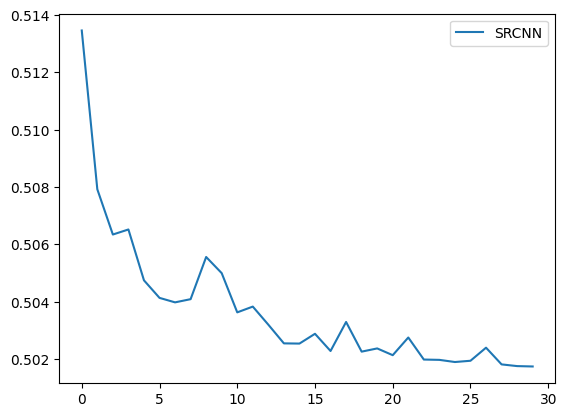

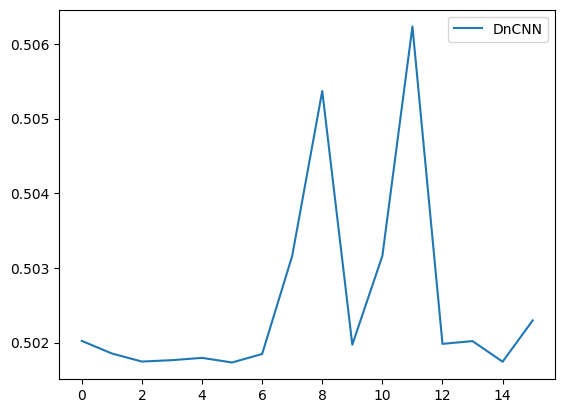

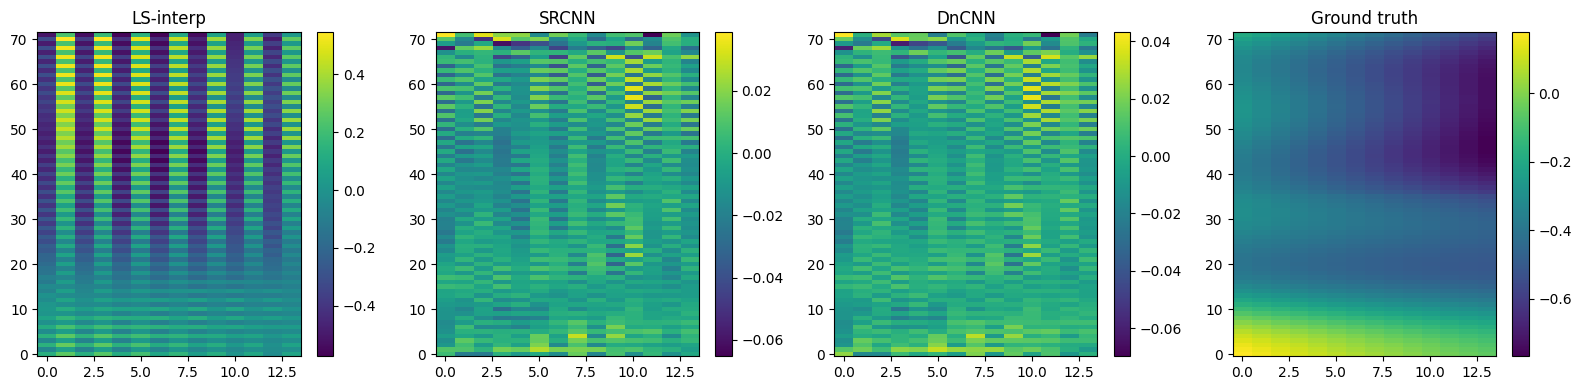

In [ ]:
# Run this entire block in one Colab or Jupyter cell
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from scipy import interpolate

import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Subtract
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ---------------------------------------------------------------------
# 1) Utility functions: PSNR and pilot interpolation → full grid
# ---------------------------------------------------------------------
def psnr(target, ref):
    diff = np.asarray(ref, np.float32) - np.asarray(target, np.float32)
    rmse = np.sqrt(np.mean(diff**2))
    return 20 * math.log10(255. / (rmse + 1e-12))

def interpolation(noisy, pilots, method='rbf'):
    N = noisy.shape[0]
    data = np.zeros((N,72,14,2), dtype=np.float32)
    data[...,0] = noisy.real
    data[...,1] = noisy.imag

    # pick the right pilot pattern
    if pilots == 48:
        idx = ([14*i   for i in range(1,72,6)] +
               [4+14*i for i in range(4,72,6)] +
               [7+14*i for i in range(1,72,6)] +
               [11+14*i for i in range(4,72,6)])
    elif pilots == 16:
        idx = ([4+14*i for i in range(1,72,9)] +
               [9+14*i for i in range(4,72,9)])
    elif pilots == 24:
        idx = ([14*i   for i in range(1,72,9)] +
               [6+14*i  for i in range(4,72,9)] +
               [11+14*i for i in range(1,72,9)])
    elif pilots == 8:
        idx = ([4+14*i for i in range(5,72,18)] +
               [9+14*i for i in range(8,72,18)])
    elif pilots == 36:
        idx = ([14*i   for i in range(1,72,6)] +
               [6+14*i  for i in range(4,72,6)] +
               [11+14*i for i in range(1,72,6)])
    else:
        raise ValueError("Unsupported pilot count")

    r, c = np.array(idx)//14, np.array(idx)%14
    Xg, Yg = np.meshgrid(np.arange(72), np.arange(14), indexing='ij')
    out = np.zeros((N,72,14,2), dtype=np.float32)

    for n in range(N):
        for comp in (0,1):
            z = data[n, r, c, comp]
            if method=='rbf':
                f = interpolate.Rbf(r, c, z, function='gaussian')
                out[n,...,comp] = f(Xg, Yg)
            else:
                tck = interpolate.bisplrep(r, c, z)
                out[n,...,comp] = interpolate.bisplev(np.arange(72), np.arange(14), tck)

    return out.reshape(N*2, 72, 14, 1)

# ---------------------------------------------------------------------
# 2) Model definitions: SRCNN & DnCNN
# ---------------------------------------------------------------------
def build_SRCNN():
    inp = Input((72,14,1))
    x = Conv2D(64,(9,9),activation='relu',kernel_initializer='he_normal',padding='same')(inp)
    x = Conv2D(32,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(x)
    out = Conv2D(1,(5,5),kernel_initializer='he_normal',padding='same')(x)
    m = Model(inp,out)
    m.compile(Adam(1e-3), loss='mse', metrics=['mse'])
    return m

def build_DnCNN():
    inp = Input((None,None,1))
    x = Conv2D(64,(3,3),padding='same',activation='relu')(inp)
    for _ in range(18):
        x = Conv2D(64,(3,3),padding='same')(x)
        x = BatchNormalization(epsilon=1e-3)(x)
        x = Activation('relu')(x)
    noise = Conv2D(1,(3,3),padding='same')(x)
    out   = Subtract()([inp, noise])
    m = Model(inp,out)
    m.compile(Adam(1e-3), loss='mse', metrics=['mse'])
    return m

# ---------------------------------------------------------------------
# 3) Training helpers (30 epochs each) with correct checkpoint names
# ---------------------------------------------------------------------
def train_SRCNN(X_tr, Y_tr, X_val, Y_val, chan, npilots, snr):
    Path("weights").mkdir(exist_ok=True)
    model = build_SRCNN()
    ck = ModelCheckpoint(
        f"weights/SRCNN_{chan}_{npilots}_{snr}.weights.h5",
        monitor='val_loss', save_best_only=True,
        save_weights_only=True, verbose=1
    )
    es = EarlyStopping(patience=10, restore_best_weights=True)
    hist = model.fit(
        X_tr, Y_tr, validation_data=(X_val,Y_val),
        epochs=30, batch_size=128,
        callbacks=[ck, es], verbose=2
    )
    return model, hist

def train_DnCNN(Z_tr, Y_tr, Z_val, Y_val, chan, npilots, snr):
    Path("weights").mkdir(exist_ok=True)
    model = build_DnCNN()
    ck = ModelCheckpoint(
        f"weights/DnCNN_{chan}_{npilots}_{snr}.weights.h5",
        monitor='val_loss', save_best_only=True,
        save_weights_only=True, verbose=1
    )
    es = EarlyStopping(patience=10, restore_best_weights=True)
    hist = model.fit(
        Z_tr, Y_tr, validation_data=(Z_val,Y_val),
        epochs=30, batch_size=128,
        callbacks=[ck, es], verbose=2
    )
    return model, hist

# ---------------------------------------------------------------------
# 4) Prediction helpers
# ---------------------------------------------------------------------
def predict_SRCNN(X, chan, npilots, snr):
    m = build_SRCNN()
    m.load_weights(f"weights/SRCNN_{chan}_{npilots}_{snr}.weights.h5")
    return m.predict(X, batch_size=128, verbose=1)

def predict_DnCNN(Z, chan, npilots, snr):
    m = build_DnCNN()
    m.load_weights(f"weights/DnCNN_{chan}_{npilots}_{snr}.weights.h5")
    return m.predict(Z, batch_size=128, verbose=1)

# ---------------------------------------------------------------------
# 5) Main: load, train, predict, eval & plot
# ---------------------------------------------------------------------
if __name__ == "__main__":
    channel_model = "VehA"
    SNR           = 22
    pilots        = 48

    # load .mat files
    perfect     = loadmat(f"/content/drive/MyDrive/Projects/Akash/Perfect_{channel_model}.mat")['My_perfect_H']
    noisy_input = loadmat(f"/content/drive/MyDrive/Projects/Akash/Noisy_{channel_model}_SNR_{SNR}.mat")["My_noisy_H"]

    # LS‑interpolate → full grid
    X = interpolation(noisy_input, pilots, method="rbf")

    # build labels Y
    N    = perfect.shape[0]
    Ytmp = np.zeros((N,72,14,2), dtype=np.float32)
    Ytmp[...,0] = perfect.real
    Ytmp[...,1] = perfect.imag
    Y    = Ytmp.transpose(3,0,1,2).reshape(2*N,72,14,1)

    # train/val split
    mask      = np.random.rand(len(Y)) < (1/9)
    X_tr,Y_tr = X[mask], Y[mask]
    X_val,Y_val = X[~mask], Y[~mask]

    # 6.1) SRCNN
    _, hist_src  = train_SRCNN(X_tr, Y_tr, X_val, Y_val,
                               channel_model, pilots, SNR)
    pred_src_val = predict_SRCNN(X_val, channel_model, pilots, SNR)

    # 6.2) DnCNN — train on the SRCNN outputs
    src_out_tr  = predict_SRCNN(X_tr, channel_model, pilots, SNR)
    src_out_val = pred_src_val
    _, hist_dn   = train_DnCNN(src_out_tr, Y_tr, src_out_val, Y_val,
                               channel_model, pilots, SNR)
    pred_dn_val  = predict_DnCNN(src_out_val, channel_model, pilots, SNR)

    # 7) PSNR
    ps_src = np.mean([psnr(Y_val[i].squeeze(), pred_src_val[i].squeeze())
                      for i in range(len(pred_src_val))])
    ps_dn  = np.mean([psnr(Y_val[i].squeeze(), pred_dn_val[i].squeeze())
                      for i in range(len(pred_dn_val))])
    print(f"SRCNN  val PSNR: {ps_src:.2f} dB")
    print(f"DnCNN  val PSNR: {ps_dn:.2f} dB")

    # 8) Plot validation losses
    plt.figure(); plt.plot(hist_src.history["val_loss"], label="SRCNN"); plt.legend(); plt.show()
    plt.figure(); plt.plot(hist_dn.history["val_loss"],  label="DnCNN");  plt.legend(); plt.show()

    # 9) Show one example
    k = 0
    imgs   = [X_val[k].squeeze(), pred_src_val[k].squeeze(),
              pred_dn_val[k].squeeze(), Y_val[k].squeeze()]
    titles = ["LS‐interp", "SRCNN", "DnCNN", "Ground truth"]
    fig, ax = plt.subplots(1,4, figsize=(16,4))
    for a,im,tt in zip(ax, imgs, titles):
        pcm = a.imshow(im, origin="lower", aspect="auto")
        a.set_title(tt)
        fig.colorbar(pcm, ax=a)
    plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import math
from scipy import interpolate
from scipy.io import loadmat

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    Subtract
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def psnr(target, ref):
    target_data = np.array(target, dtype=float)
    ref_data    = np.array(ref, dtype=float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff.flatten()**2))
    return 20 * math.log10(255. / (rmse + 1e-12))

def interpolation(noisy, SNR, Number_of_pilot, interp):
    noisy_image = np.zeros((40000,72,14,2), dtype=np.float32)
    noisy_image[...,0] = noisy.real
    noisy_image[...,1] = noisy.imag

    if Number_of_pilot == 48:
        idx = ([14*i   for i in range(1,72,6)] +
               [4+14*i for i in range(4,72,6)] +
               [7+14*i for i in range(1,72,6)] +
               [11+14*i for i in range(4,72,6)])
    elif Number_of_pilot == 16:
        idx = ([4+14*i for i in range(1,72,9)] +
               [9+14*i for i in range(4,72,9)])
    elif Number_of_pilot == 24:
        idx = ([14*i   for i in range(1,72,9)] +
               [6+14*i  for i in range(4,72,9)] +
               [11+14*i for i in range(1,72,9)])
    elif Number_of_pilot == 8:
        idx = ([4+14*i for i in range(5,72,18)] +
               [9+14*i for i in range(8,72,18)])
    elif Number_of_pilot == 36:
        idx = ([14*i   for i in range(1,72,6)] +
               [6+14*i  for i in range(4,72,6)] +
               [11+14*i for i in range(1,72,6)])
    else:
        raise ValueError("Unsupported pilot count")

    r = np.array(idx)//14
    c = np.array(idx)%14
    Xg, Yg = np.meshgrid(np.arange(72), np.arange(14), indexing='ij')
    out = np.zeros((noisy.shape[0],72,14,2), dtype=np.float32)

    for n in range(noisy.shape[0]):
        for comp in (0,1):
            z = noisy_image[n, r, c, comp]
            if interp == 'rbf':
                f = interpolate.Rbf(r, c, z, function='gaussian')
                out[n,...,comp] = f(Xg, Yg)
            else:
                tck = interpolate.bisplrep(r, c, z)
                out[n,...,comp] = interpolate.bisplev(np.arange(72), np.arange(14), tck)

    # stack real+imag as separate “images”
    return out.reshape(noisy.shape[0]*2, 72, 14, 1)

def SRCNN_model():
    inp = Input((72,14,1))
    x = Conv2D(64, (9,9), activation='relu',
               kernel_initializer='he_normal', padding='same')(inp)
    x = Conv2D(32, (1,1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    out = Conv2D(1, (5,5),
                 kernel_initializer='he_normal', padding='same')(x)
    m = Model(inputs=inp, outputs=out)
    m.compile(Adam(1e-3), loss='mse', metrics=['mse'])
    return m

def DNCNN_model():
    inp = Input((None,None,1))
    x = Conv2D(64, (3,3), padding='same', activation='relu')(inp)
    for _ in range(18):
        x = Conv2D(64, (3,3), padding='same')(x)
        x = BatchNormalization(epsilon=1e-3)(x)
        x = Activation('relu')(x)
    noise = Conv2D(1, (3,3), padding='same')(x)
    out   = Subtract()([inp, noise])
    m     = Model(inputs=inp, outputs=out)
    m.compile(Adam(1e-3), loss='mse', metrics=['mse'])
    return m

def SRCNN_train(X_tr, Y_tr, X_val, Y_val, channel_model, num_pilots, SNR):
    m  = SRCNN_model()
    ck = ModelCheckpoint(
        f"weights/SRCNN_{channel_model}{num_pilots}{SNR}.weights.h5",
        monitor='val_loss', save_best_only=True,
        save_weights_only=True, verbose=1
    )
    h = m.fit(
        X_tr, Y_tr,
        validation_data=(X_val, Y_val),
        epochs=300, batch_size=128,
        callbacks=[ck], verbose=2
    )
    return m, h

def SRCNN_predict(X, channel_model, num_pilots, SNR):
    m = SRCNN_model()
    m.load_weights(
        f"weights/SRCNN_{channel_model}{num_pilots}{SNR}.weights.h5"
    )
    return m.predict(X, batch_size=128, verbose=1)

def DNCNN_train(X_tr, Y_tr, X_val, Y_val, channel_model, num_pilots, SNR):
    m  = DNCNN_model()
    ck = ModelCheckpoint(
        f"weights/DNCNN_{channel_model}{num_pilots}{SNR}.weights.h5",
        monitor='val_loss', save_best_only=True,
        save_weights_only=True, verbose=1
    )
    h = m.fit(
        X_tr, Y_tr,
        validation_data=(X_val, Y_val),
        epochs=200, batch_size=128,
        callbacks=[ck], verbose=2
    )
    return m, h

def DNCNN_predict(X, channel_model, num_pilots, SNR):
    m = DNCNN_model()
    m.load_weights(
        f"weights/DNCNN_{channel_model}{num_pilots}{SNR}.weights.h5"
    )
    return m.predict(X, batch_size=128, verbose=1)

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.51455, saving model to weights/SRCNN_VehA4822.weights.h5
71/71 - 8s - 118ms/step - loss: 0.5723 - mse: 0.5723 - val_loss: 0.5145 - val_mse: 0.5145
Epoch 2/300

Epoch 2: val_loss improved from 0.51455 to 0.51348, saving model to weights/SRCNN_VehA4822.weights.h5
71/71 - 2s - 22ms/step - loss: 0.5174 - mse: 0.5174 - val_loss: 0.5135 - val_mse: 0.5135
Epoch 3/300

Epoch 3: val_loss improved from 0.51348 to 0.51045, saving model to weights/SRCNN_VehA4822.weights.h5
71/71 - 2s - 22ms/step - loss: 0.5129 - mse: 0.5129 - val_loss: 0.5104 - val_mse: 0.5104
Epoch 4/300

Epoch 4: val_loss did not improve from 0.51045
71/71 - 2s - 22ms/step - loss: 0.5176 - mse: 0.5176 - val_loss: 0.5104 - val_mse: 0.5104
Epoch 5/300

Epoch 5: val_loss improved from 0.51045 to 0.50692, saving model to weights/SRCNN_VehA4822.weights.h5
71/71 - 2s - 22ms/step - loss: 0.5106 - mse: 0.5106 - val_loss: 0.5069 - val_mse: 0.5069
Epoch 6/300

Epoch 6: val_loss improve

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SRCNN validation PSNR: 52.88 dB
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.50209, saving model to weights/DNCNN_VehA4822.weights.h5
71/71 - 31s - 439ms/step - loss: 0.5672 - mse: 0.5672 - val_loss: 0.5021 - val_mse: 0.5021
Epoch 2/200

Epoch 2: val_loss did not improve from 0.50209
71/71 - 6s - 82ms/step - loss: 0.5063 - mse: 0.5063 - val_loss: 0.5072 - val_mse: 0.5072
Epoch 3/200

Epoch 3: val_loss improved from 0.50209 to 0.50147, saving model to weights/DNCNN_VehA4822.weights.h5
71/71 - 6s - 85ms/step - loss: 0.5050 - mse: 0.5050 - val_loss: 0.5015 - val_mse: 0.5015
Epoch 4/200

Epoch 4: val_loss did not improve from 0.50147
71/71 - 6s - 81ms/step - loss: 0.5056 - mse: 0.5056 - val_loss: 0.5055 - val_mse: 0.5055
Epoch 5/200

Epoch 5: val_loss did not improve from 0.50147
71/71 - 6s - 82ms/step - loss: 0.5053 - mse: 0.5053 - val_loss: 0.5022 - val_mse: 0.5022
Epoch 6/200

Epoch 6: val_loss impr

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 154 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
DNCNN validation PSNR: 52.88 dB


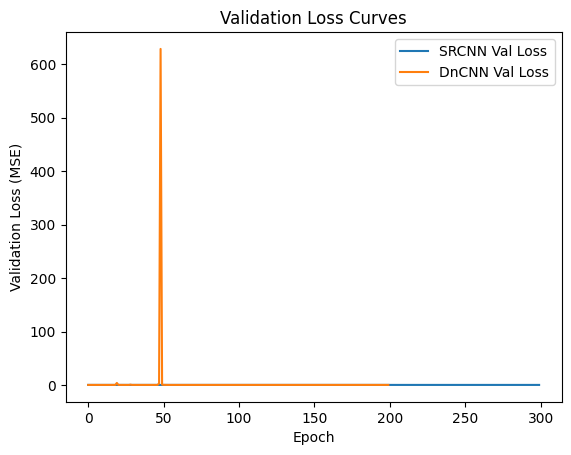

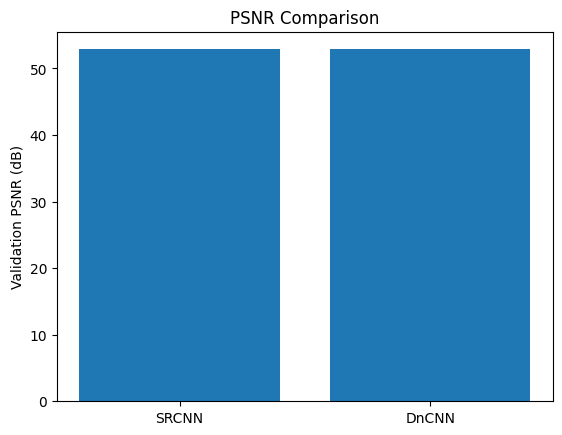

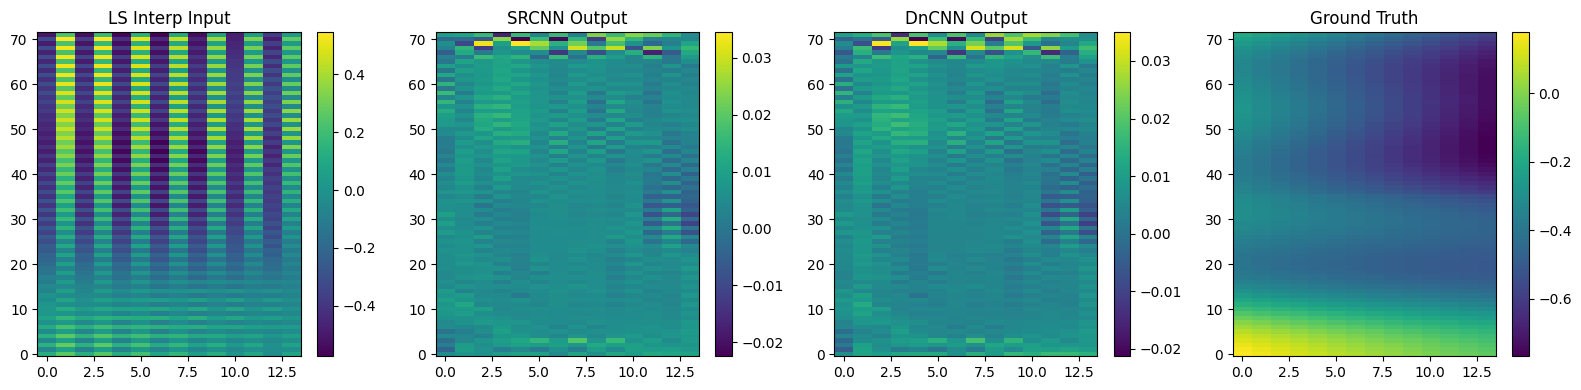

In [ ]:
import numpy
import math
#from models import interpolation , SRCNN_train , SRCNN_model, SRCNN_predict , DNCNN_train , DNCNN_model , DNCNN_predict
#from scipy.misc import imresize
from scipy.io import loadmat
import matplotlib.pyplot as plt



if __name__ == "__main__":
    # load datasets
    channel_model = "VehA"
    SNR = 22
    Number_of_pilots = 48
    perfect = loadmat("/content/drive/MyDrive/Projects/Akash/Perfect_"+ 'VehA.mat')['My_perfect_H']
    noisy_input = loadmat("/content/drive/MyDrive/Projects/Akash/Noisy_" + channel_model + "" + "_SNR_" + str(SNR) + ".mat") ["My_noisy_H" ]

    interp_noisy = interpolation(noisy_input , SNR , Number_of_pilots , 'rbf')

    perfect_image = numpy.zeros((len(perfect),72,14,2))
    perfect_image[:,:,:,0] = numpy.real(perfect)
    perfect_image[:,:,:,1] = numpy.imag(perfect)
    perfect_image = numpy.concatenate((perfect_image[:,:,:,0], perfect_image[:,:,:,1]), axis=0).reshape(2*len(perfect), 72, 14, 1)


    ####### ------ training SRCNN ------ #######
    idx_random = numpy.random.rand(len(perfect_image)) < (1/9)  # uses 32000 from 36000 as training and the rest as validation
    train_data, train_label = interp_noisy[idx_random,:,:,:] , perfect_image[idx_random,:,:,:]
    val_data, val_label = interp_noisy[~idx_random,:,:,:] , perfect_image[~idx_random,:,:,:]
    srcnn_model, hist_src = SRCNN_train(
        train_data, train_label,
        val_data,   val_label,
        channel_model, Number_of_pilots, SNR
    )
    srcnn_model.save(f"/content/drive/MyDrive/Projects/Akash/saved_models/srcnn_{channel_model}{Number_of_pilots}{SNR}.keras")


    ####### ------ prediction using SRCNN ------ #######
    srcnn_pred_train = SRCNN_predict(train_data, channel_model , Number_of_pilots , SNR)
    srcnn_pred_val = SRCNN_predict(val_data, channel_model , Number_of_pilots , SNR)

    # compute PSNR on validation
    psnr_src_val = numpy.mean([
        psnr(val_label[i].squeeze(), srcnn_pred_val[i].squeeze())
        for i in range(len(srcnn_pred_val))
    ])
    print(f"SRCNN validation PSNR: {psnr_src_val:.2f} dB")


    ####### ------ training DNCNN ------ #######
    # DNCNN_train(input_data, channel_model , num_pilots , SNR)
    dncnn_model, hist_dn = DNCNN_train(
        srcnn_pred_train,    # the LS‐interpolated inputs
        train_label,         # the ground‐truth “perfect” images
        srcnn_pred_val,      # validation inputs
        val_label,           # validation labels
        channel_model,
        Number_of_pilots,
        SNR
    )

    dncnn_model.save(f"/content/drive/MyDrive/Projects/Akash/saved_models/dncnn_{channel_model}{Number_of_pilots}{SNR}.keras")

    ####### ------ prediction using DNCNN ------ #######
    dncnn_pred_train = DNCNN_predict(srcnn_pred_train, channel_model, Number_of_pilots, SNR)
    dncnn_pred_val   = DNCNN_predict(srcnn_pred_val,   channel_model, Number_of_pilots, SNR)

    psnr_dn_val = numpy.mean([
        psnr(val_label[i].squeeze(), dncnn_pred_val[i].squeeze())
        for i in range(len(dncnn_pred_val))
    ])
    print(f"DNCNN validation PSNR: {psnr_dn_val:.2f} dB")


    # ——— Plotting section ———
    # 1) Validation loss curves
    plt.figure()
    plt.plot(hist_src.history['val_loss'], label='SRCNN Val Loss')
    plt.plot(hist_dn.history['val_loss'], label='DnCNN Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss (MSE)')
    plt.legend()
    plt.title('Validation Loss Curves')
    plt.show()

    # 2) PSNR bar comparison
    plt.figure()
    plt.bar(['SRCNN','DnCNN'], [psnr_src_val, psnr_dn_val])
    plt.ylabel('Validation PSNR (dB)')
    plt.title('PSNR Comparison')
    plt.show()

    # 3) Visualize one example (first validation sample)
    k = 0
    examples = [
        val_data[k].squeeze(),
        srcnn_pred_val[k].squeeze(),
        dncnn_pred_val[k].squeeze(),
        val_label[k].squeeze()
    ]
    titles = ['LS Interp Input','SRCNN Output','DnCNN Output','Ground Truth']
    fig, axes = plt.subplots(1,4,figsize=(16,4))
    for ax, img, tt in zip(axes, examples, titles):
        pcm = ax.imshow(img, origin='lower', aspect='auto')
        ax.set_title(tt)
        fig.colorbar(pcm, ax=ax)
    plt.tight_layout()
    plt.show()
